In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import datasets
from torchvision import transforms as T
import torchutils as tu
from typing import Tuple
from PIL import Image
import os
import pandas as pd

In [2]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# if torch.backends.mps.is_available(): device='mps'
print(DEVICE)

cpu


In [45]:
#  Пути к распакованным данным
train_cleaned_path = '/home/valerie/repositories/shabby-docs-denoise/train/train/train_cleaned'
train_noisy_path = '/home/valerie/repositories/shabby-docs-denoise/train/train/train_shabby'
valid_cleaned_path = '/home/valerie/repositories/shabby-docs-denoise/validate/validate/validate_cleaned'
valid_noisy_path = '/home/valerie/repositories/shabby-docs-denoise/validate/validate/validate_shabby'
test_cleaned_path = '/home/valerie/repositories/shabby-docs-denoise/test/test/test_cleaned'
test_noisy_path = '/home/valerie/repositories/shabby-docs-denoise/test/test/test_shabby'

BATCH_SIZE = 64

# Преобразования для обучения и тестирования
transform = T.Compose([
    T.Resize((400, 400)),
    T.ToTensor()
])

class NoisyDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = [os.path.join(root, img) for img in os.listdir(root) if os.path.isfile(os.path.join(root, img))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image

# Создание загрузчиков
train_clean_loader = DataLoader(
    NoisyDataset(root=train_cleaned_path, transform=transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)

train_noisy_loader = DataLoader(
    NoisyDataset(root=train_noisy_path, transform=transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)

valid_clean_loader = DataLoader(
    NoisyDataset(root=valid_cleaned_path, transform=transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)

valid_noisy_loader = DataLoader(
    NoisyDataset(root=valid_noisy_path, transform=transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)

test_clean_loader = DataLoader(
    NoisyDataset(root=test_cleaned_path, transform=transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)
test_noisy_loader = DataLoader(
    NoisyDataset(root=test_noisy_path, transform=transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)


In [63]:
class DenoiserAE(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder 
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=4),
            nn.BatchNorm2d(128),
            nn.SELU()
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.SELU()
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=4),
            nn.BatchNorm2d(32),
            nn.SELU()
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=2, stride=2),
            nn.BatchNorm2d(1),
            nn.SELU()
            )
        
        #decoder
        
        self.conv1_t = nn.Sequential(
            nn.ConvTranspose2d(1, 128, kernel_size=2),
            nn.BatchNorm2d(128),
            nn.SELU()
            )
        self.conv2_t = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.Sigmoid()
            )
        self.conv3_t = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2),
            nn.BatchNorm2d(32),
            nn.SELU()
            )
        self.conv4_t = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
            )        
    def encode(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

    def decode(self, x):
        x = self.conv1_t(x)
        x = self.conv2_t(x)
        x = self.conv3_t(x)
        x = self.conv4_t(x)
        return x

    def forward(self, x):
        latent = self.encode(x)
        out = self.decode(latent)      
        return out

denoiser = DenoiserAE().to(DEVICE)
tu.get_model_summary(denoiser, torch.randn(1, 1, 400, 400, device=DEVICE))


Layer                              Kernel              Output         Params            FLOPs
0_conv1.Conv2d_0                [1, 128, 4, 4]   [1, 128, 397, 397]     2,176     342,957,184
1_conv1.BatchNorm2d_1                    [128]   [1, 128, 397, 397]       256      80,695,808
2_conv1.SELU_2                               -   [1, 128, 397, 397]         0               0
3_conv2.Conv2d_0               [128, 64, 2, 2]    [1, 64, 198, 198]    32,832   1,287,145,728
4_conv2.BatchNorm2d_1                     [64]    [1, 64, 198, 198]       128      10,036,224
5_conv2.SELU_2                               -    [1, 64, 198, 198]         0               0
6_conv3.Conv2d_0                [64, 32, 4, 4]    [1, 32, 195, 195]    32,800   1,247,220,000
7_conv3.BatchNorm2d_1                     [32]    [1, 32, 195, 195]        64       4,867,200
8_conv3.SELU_2                               -    [1, 32, 195, 195]         0               0
9_conv4.Conv2d_0                 [32, 1, 2, 2]       [1, 1, 

In [47]:
class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.SELU()
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, padding=1),
            nn.LazyBatchNorm2d(),
            nn.SELU()
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.Sigmoid()
        )
        self.layer1_t = nn.Sequential(
            nn.ConvTranspose2d(1, 64, kernel_size=3, padding=1),
            nn.LazyBatchNorm2d(),
            nn.SELU()
        )
        self.layer2_t = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU()
        )
        self.layer3_t = nn.Sequential(
            nn.ConvTranspose2d(32, 4, kernel_size=3, padding=1),
            nn.LazyBatchNorm2d(),
            nn.Sigmoid()
        )
        self.layer4_t = nn.Sequential(
            nn.ConvTranspose2d(4, 1, kernel_size=1, padding=1),
            nn.LazyBatchNorm2d(),
            nn.Sigmoid()
        )
    def encode(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x
    def decode(self, x):
        x = self.layer1_t(x)
        x = self.layer2_t(x)
        x = self.layer3_t(x)
        x = self.layer4_t(x)
        return x
    def forward(self, x):
        latent = self.encode(x)
        out = self.decode(latent)
        return out

denoiser = ConvAE().to(DEVICE)
tu.get_model_summary(denoiser, torch.randn(1, 1, 400, 400, device=DEVICE))

Layer                               Kernel            Output         Params           FLOPs
0_layer1.Conv2d_0                 [1, 4, 2, 2]    [1, 4, 401, 401]       20       3,216,020
1_layer1.LazyBatchNorm2d_1                 [4]    [1, 4, 401, 401]        8       2,572,816
2_layer1.SELU_2                              -    [1, 4, 401, 401]        0               0
3_layer2.Conv2d_0                [4, 32, 3, 3]   [1, 32, 401, 401]    1,184     190,388,384
4_layer2.LazyBatchNorm2d_1                [32]   [1, 32, 401, 401]       64      20,582,528
5_layer2.SELU_2                              -   [1, 32, 401, 401]        0               0
6_layer3.Conv2d_0               [32, 64, 3, 3]   [1, 64, 401, 401]   18,496   2,974,175,296
7_layer3.LazyBatchNorm2d_1                [64]   [1, 64, 401, 401]      128      41,165,056
8_layer3.ReLU_2                              -   [1, 64, 401, 401]        0               0
9_layer4.Conv2d_0                [64, 1, 2, 2]    [1, 1, 402, 402]      257     

/home/valerie/repositories/nn_project/nn_project_env/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [53]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder 
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4),
            nn.BatchNorm2d(32),
            nn.SELU()
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 8, kernel_size=2),
            nn.BatchNorm2d(8),
            nn.SELU()
            )
        
        self.pool = nn.MaxPool2d(2, 2, return_indices=True, ceil_mode=True) #<<<<<< Bottleneck
        
        #decoder
        # Как работает Conv2dTranspose https://github.com/vdumoulin/conv_arithmetic

        self.unpool = nn.MaxUnpool2d(2, 2)
        
        self.conv1_t = nn.Sequential(
            nn.ConvTranspose2d(8, 32, kernel_size=2),
            nn.BatchNorm2d(32),
            nn.SELU()
            )
        self.conv2_t = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4),
            nn.LazyBatchNorm2d(),
            nn.Sigmoid()
            )     

    def encode(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x, indicies = self.pool(x) # ⟸ bottleneck
        return x, indicies

    def decode(self, x, indicies):
        x = self.unpool(x, indicies)
        x = self.conv1_t(x)
        x = self.conv2_t(x)
        return x

    def forward(self, x):
        latent, indicies = self.encode(x)
        out = self.decode(latent, indicies)      
        return out
    
denoiser = ConvAutoencoder().to(DEVICE)
tu.get_model_summary(denoiser, torch.randn(1, 1, 400, 400, device=DEVICE))

Layer                             Kernel            Output         Params         FLOPs
0_conv1.Conv2d_0               [1, 32, 4, 4]   [1, 32, 397, 397]      544    85,739,296
1_conv1.BatchNorm2d_1                   [32]   [1, 32, 397, 397]       64    20,173,952
2_conv1.SELU_2                             -   [1, 32, 397, 397]        0             0
3_conv2.Conv2d_0               [32, 8, 2, 2]    [1, 8, 396, 396]    1,032   161,834,112
4_conv2.BatchNorm2d_1                    [8]    [1, 8, 396, 396]       16     5,018,112
5_conv2.SELU_2                             -    [1, 8, 396, 396]        0             0
6_pool                                     -    [1, 8, 198, 198]        0             0
7_unpool                                   -    [1, 8, 396, 396]        0             0
8_conv1_t.ConvTranspose2d_0    [32, 8, 2, 2]   [1, 32, 397, 397]    1,056   166,435,104
9_conv1_t.BatchNorm2d_1                 [32]   [1, 32, 397, 397]       64    20,173,952
10_conv1_t.SELU_2               

In [64]:
# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = optim.Adam(denoiser.parameters(), lr=0.005)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.01)

Epoch: 1 	Training Loss: 0.223 Valid loss: 0.475 lr:0.010
Epoch: 1 	Training RMSE: 0.472 Valid RMSE: 0.689 lr:0.010


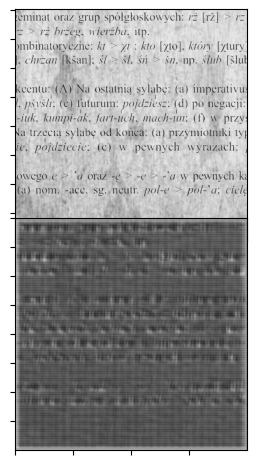

Epoch: 2 	Training Loss: 0.182 Valid loss: 0.147 lr:0.007
Epoch: 2 	Training RMSE: 0.427 Valid RMSE: 0.383 lr:0.007


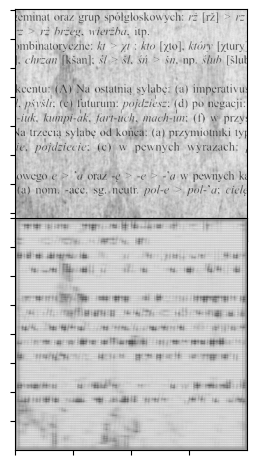

Epoch: 3 	Training Loss: 0.157 Valid loss: 0.418 lr:0.007
Epoch: 3 	Training RMSE: 0.396 Valid RMSE: 0.646 lr:0.007


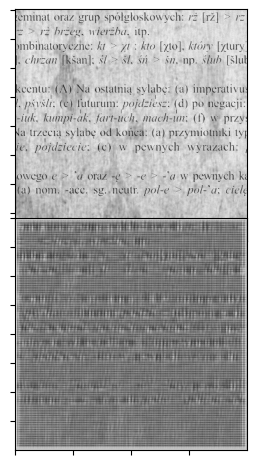

Epoch: 4 	Training Loss: 0.137 Valid loss: 0.174 lr:0.010
Epoch: 4 	Training RMSE: 0.370 Valid RMSE: 0.417 lr:0.010


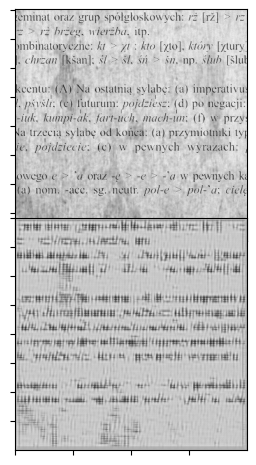

Epoch: 5 	Training Loss: 0.121 Valid loss: 0.136 lr:0.005
Epoch: 5 	Training RMSE: 0.348 Valid RMSE: 0.369 lr:0.005


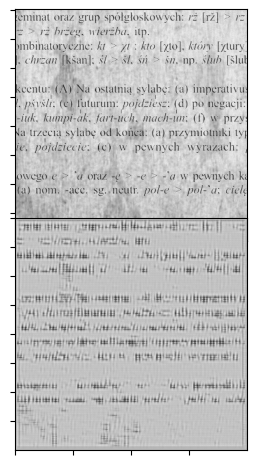

Epoch: 6 	Training Loss: 0.107 Valid loss: 0.114 lr:0.010
Epoch: 6 	Training RMSE: 0.327 Valid RMSE: 0.337 lr:0.010


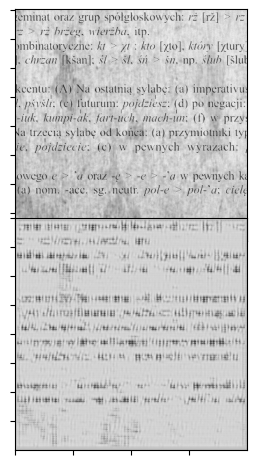

Epoch: 7 	Training Loss: 0.096 Valid loss: 0.079 lr:0.007
Epoch: 7 	Training RMSE: 0.310 Valid RMSE: 0.281 lr:0.007


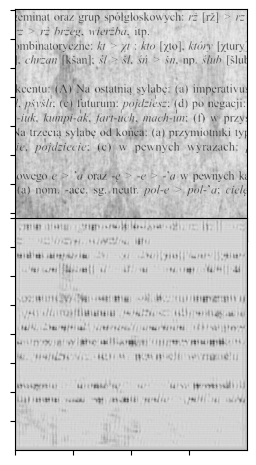

Epoch: 8 	Training Loss: 0.087 Valid loss: 0.102 lr:0.007
Epoch: 8 	Training RMSE: 0.295 Valid RMSE: 0.319 lr:0.007


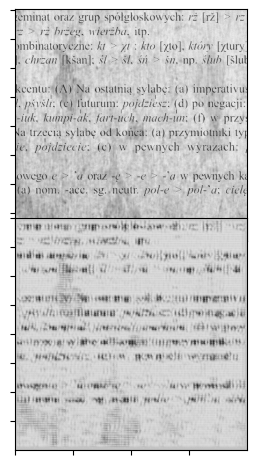

Epoch: 9 	Training Loss: 0.080 Valid loss: 0.092 lr:0.010
Epoch: 9 	Training RMSE: 0.282 Valid RMSE: 0.304 lr:0.010


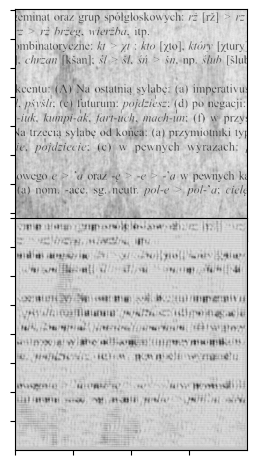

Epoch: 10 	Training Loss: 0.074 Valid loss: 0.087 lr:0.005
Epoch: 10 	Training RMSE: 0.272 Valid RMSE: 0.295 lr:0.005


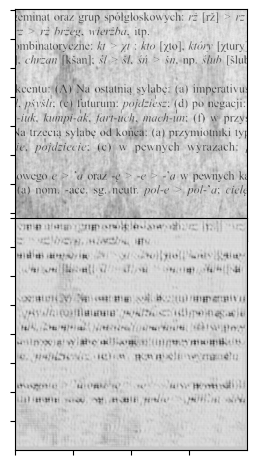

Model weights saved at epoch 10
Epoch: 11 	Training Loss: 0.067 Valid loss: 0.089 lr:0.010
Epoch: 11 	Training RMSE: 0.260 Valid RMSE: 0.299 lr:0.010


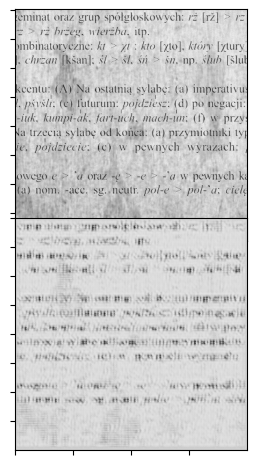

In [65]:
# Обучение модели
weights_dir = '/home/valerie/cv_project/weights'
os.makedirs(weights_dir, exist_ok=True)

n_epochs = 11
train_loss = []
valid_loss = []
train_metric = []
valid_metric = []
lrs = []

for epoch in range(1, n_epochs + 1):
    loss_batch = 0.0
    denoiser.train()

    for data_cleaned, data_noisy in zip(train_clean_loader, train_noisy_loader):
        data_cleaned, data_noisy = data_cleaned[0].to(DEVICE), data_noisy[0].to(DEVICE)
        data_noisy = data_noisy.unsqueeze(1)

        optimizer.zero_grad()
        outputs = denoiser(data_noisy)
        loss = criterion(outputs, data_cleaned.unsqueeze(0))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        loss_batch += loss.item()

    train_loss.append(loss_batch / len(train_clean_loader))
    train_metric.append(np.sqrt(loss_batch / len(train_clean_loader)))

    loss_batch = 0.0

    # Validation (используем те же данные, что и для тренировки)
    denoiser.eval()

    for data_cleaned, data_noisy in zip(valid_clean_loader, valid_noisy_loader):
        data_cleaned, data_noisy = data_cleaned[0].to(DEVICE), data_noisy[0].to(DEVICE)
        data_noisy = data_noisy.unsqueeze(1)

        with torch.no_grad():
            outputs = denoiser(data_noisy)

        loss = criterion(outputs, data_cleaned.unsqueeze(0))
        loss_batch += loss.item()

    valid_loss.append(loss_batch / len(valid_clean_loader))
    valid_metric.append(np.sqrt(loss_batch / len(valid_clean_loader)))

    if epoch % 1 == 0:
        lrs.append(optimizer.param_groups[0]["lr"])
        print(f'Epoch: {epoch} \tTraining Loss: {train_loss[-1]:.3f} Valid loss: {valid_loss[-1]:.3f} lr:{optimizer.param_groups[0]["lr"]:.3f}')
        print(f'Epoch: {epoch} \tTraining RMSE: {train_metric[-1]:.3f} Valid RMSE: {valid_metric[-1]:.3f} lr:{optimizer.param_groups[0]["lr"]:.3f}')
        
        # save_image(outputs.data[0].detach().cpu(), f'results/img{epoch}.jpg')
        
        fig, ax = plt.subplots(2, 1, figsize=(20, 5))
        fig.tight_layout()
        ax = ax.flatten()
        
        for pos in range(2):
            if pos < 1:
                ax[pos].imshow(torch.permute(data_noisy.data[pos].detach().cpu(), (1, 2, 0)), cmap='gray')
                ax[pos].set_yticklabels([]); ax[pos].set_xticklabels([])
            else:
                ax[pos].imshow(torch.permute(outputs.data[pos-1].detach().cpu(), (1, 2, 0)), cmap='gray')
                ax[pos].set_yticklabels([]); ax[pos].set_xticklabels([])
        plt.subplots_adjust(wspace=0, hspace=-.1)
        plt.show()

    if epoch % 10 == 0:
        weights_path = os.path.join(weights_dir, f'model_weights_epoch_{epoch}.pt')
        torch.save(denoiser.state_dict(), weights_path)
        print(f'Model weights saved at epoch {epoch}')

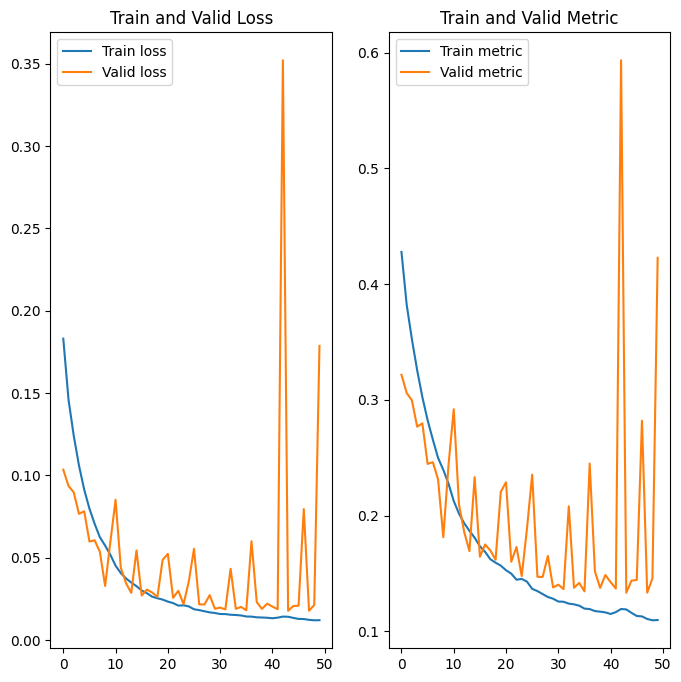

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))

# Первый график
axs[0].plot(train_loss, label='Train loss')
axs[0].plot(valid_loss, label='Valid loss')
axs[0].set_title('Train and Valid Loss')
axs[0].legend()

# Второй график
axs[1].plot(train_metric, label='Train metric')
axs[1].plot(valid_metric, label='Valid metric')
axs[1].set_title('Train and Valid Metric')
axs[1].legend()

torch.Size([400, 400])
torch.Size([1, 1, 400, 400])


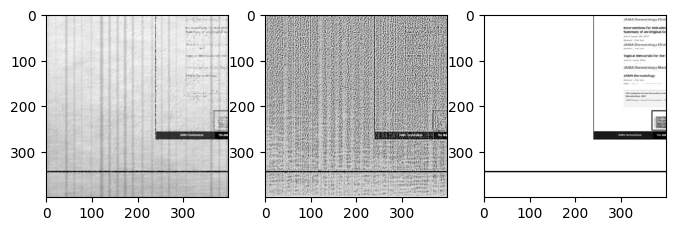

In [57]:
sample_clean = next(iter(test_clean_loader))
sample_noise = next(iter(test_noisy_loader))
# model = DenoiserAE()
# model.load_state_dict(torch.load('/home/valerie/repositories/cv_project/weights/model_weights_epoch_200.pt', map_location=DEVICE))
denoiser.to(DEVICE)
print(sample_noise[1][0].shape)
with torch.no_grad():
    outputs = denoiser(sample_noise[1][0].unsqueeze(0).unsqueeze(0).to(DEVICE))
print(outputs.shape)
_, ax = plt.subplots(1, 3, figsize=(8, 8))
ax[0].imshow(sample_noise[1][0], cmap='gray')
ax[1].imshow(outputs.squeeze(0).cpu().permute(1,2,0), cmap='gray')
ax[2].imshow(sample_clean[1][0], cmap='gray')

torch.Size([1, 400, 400])
torch.Size([1, 1, 400, 400])


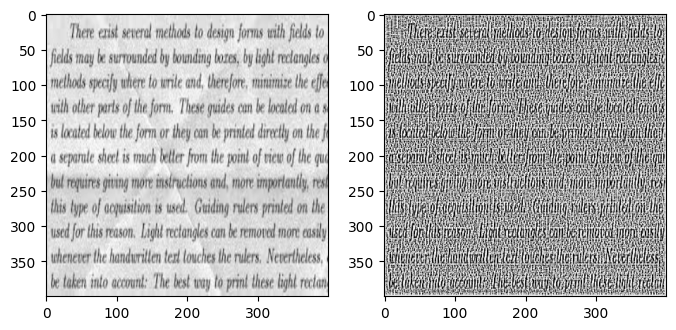

In [59]:
image = Image.open('image.jpg')
image_tensor = transform(image)
grayscale_image = torch.mean(image_tensor, dim=0, keepdim=True)
print(grayscale_image.shape)
# model.load_state_dict(torch.load('/home/valerie/repositories/cv_project/weights/model_weights_epoch_200.pt', map_location=DEVICE))
denoiser.to(DEVICE)

with torch.no_grad():
    outputs = denoiser(grayscale_image.unsqueeze(0).to(DEVICE))
print(outputs.shape)
_, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(grayscale_image.permute(1,2,0), cmap='gray')
ax[1].imshow(outputs.squeeze(0).cpu().permute(1,2,0), cmap='gray')

In [25]:
print(outputs.shape)

torch.Size([1, 1, 400, 400])


In [62]:
losses = pd.DataFrame({
    'train loss': train_loss,
    'valid loss': valid_loss   
}).to_csv('/home/valerie/cv_project/losses.csv')
metrics = pd.DataFrame({
    'train rmse': train_metric,
    'valid rmse': valid_metric   
}).to_csv('/home/valerie/cv_project/metrics.csv')

data_sizes = pd.DataFrame({'Category': ['Train', 'Valid', 'Test'],
              'Values': [len(train_noisy_loader), len(valid_noisy_loader), len(test_noisy_loader)]
              }).to_csv('/home/valerie/cv_project/data_sizes.csv')